<a href="https://colab.research.google.com/github/sindhu213/Research-Papers/blob/master/src/NMT_with_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install torchdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 2.6 MB/s 
     |████████████████████████████████| 140 kB 49.9 MB/s 
     |████████████████████████████████| 127 kB 8.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


## Neural machine translation by jointly learning to align and translate

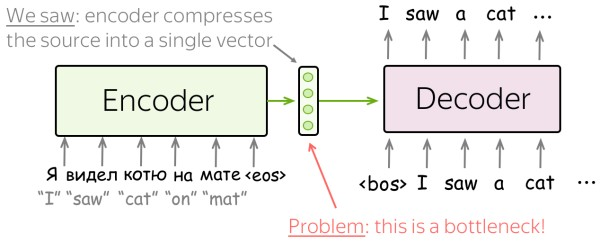

Image Source: [Lena Voita NLP](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html)

In an **Encoder-Decoder** architecture, a source sentence is encoded into a 
fixed-length context vector (which subsequently initializes the decoder network's hidden state, h<sub>0</sub>). Though it provides some context to the decoder network, it generally leads to information loss due to data compression   (most likely in long source sentences).

[*Bahdanau et al. (2016)*](https://arxiv.org/pdf/1409.0473.pdf?utm_source=ColumnsChannel) proposes a method to mitigate this problem by allowing the network to automatically search for a part of the source sentence that can predict the target token at each decoding step. It accomplishes this through the use of attention.

# Preparing Data

In [2]:
import re
import random
from typing import Tuple

import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torch.nn.utils.rnn import pad_sequence,pack_padded_sequence

from torchtext.datasets import Multi30k
from torchtext.vocab import build_vocab_from_iterator

In [3]:
## train dtype: torch.utils.data.datapipes.iter.grouping.ShardingFilterIterDataPipe
train,valid,test = Multi30k()

In [4]:
def tokenize(string):
  tokenized = re.sub(r'[^\w\s]',' ',string.lower())
  return tokenized.split()

def yield_tokens(data_iter,lang):
  for de,en in data_iter:
    if lang is 'en': yield tokenize(en)
    else: yield tokenize(de)

In [5]:
en_vocab = build_vocab_from_iterator(yield_tokens(train,'en'),min_freq=2,specials=["<unk>","<pad>","<bos>","<eos>"])
en_vocab.set_default_index(0)

de_vocab = build_vocab_from_iterator(yield_tokens(train,'de'),min_freq=2,specials=["<unk>","<pad>","<bos>","<eos>"])
de_vocab.set_default_index(0)

In [6]:
print("No. of unique tokens in en_vocab: ",len(en_vocab))
print("No. of unique tokens in de_vocab: ",len(de_vocab))

No. of unique tokens in en_vocab:  5883
No. of unique tokens in de_vocab:  7860


In [7]:
de_pipeline = lambda x: de_vocab(["<bos>",*tokenize(x),"<eos>"])
en_pipeline = lambda x: en_vocab(["<bos>",*tokenize(x),"<eos>"])

In [ ]:
class TextDataset(Dataset):

  def __init__(self,datapipe) -> None:
    self.dp = list(datapipe)

  def __len__(self) -> int:
    return len(self.dp)

  def __getitem__(self,idx) -> Tuple[str,str]:
    return self.dp[idx]

train_data = TextDataset(train)
valid_data = TextDataset(valid)
test_data = TextDataset(test)

In [9]:
print(f"len (train_data) : {len(train_data)}")
print(f"len (valid_data) : {len(valid_data)}")
print(f"len (test_data)  : {len(test_data)}")

len (train_data) : 29001
len (valid_data) : 1015
len (test_data)  : 1000


In [10]:
def collate_batch(data):
  de,en_data,en_label = [], [], []
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  for (x_batch,y_batch) in data:
    src_encoded = de_pipeline(x_batch)
    de.append(torch.tensor(src_encoded,dtype=torch.int64))
    tgt_encoded = en_pipeline(y_batch)
    en_data.append(torch.tensor(tgt_encoded[:-1],dtype=torch.int64))
    en_label.append(torch.tensor(tgt_encoded[1:],dtype=torch.int64))
  
  src = pad_sequence(de,batch_first=True,padding_value=1)
  tgt_data = pad_sequence(en_data,batch_first=True,padding_value=1)
  tgt_label = pad_sequence(en_label,batch_first=True,padding_value=1)

  return src.to(device),tgt_data.to(device),tgt_label.to(device)

In [11]:
batch_size = 64

train_dl = DataLoader(train_data,batch_size=batch_size,shuffle=True,drop_last=True,collate_fn=collate_batch)
valid_dl = DataLoader(valid_data,batch_size=batch_size,shuffle=False,drop_last=True,collate_fn=collate_batch)
test_dl = DataLoader(test_data,batch_size=batch_size,shuffle=False,drop_last=True,collate_fn=collate_batch)

# Model Architecture

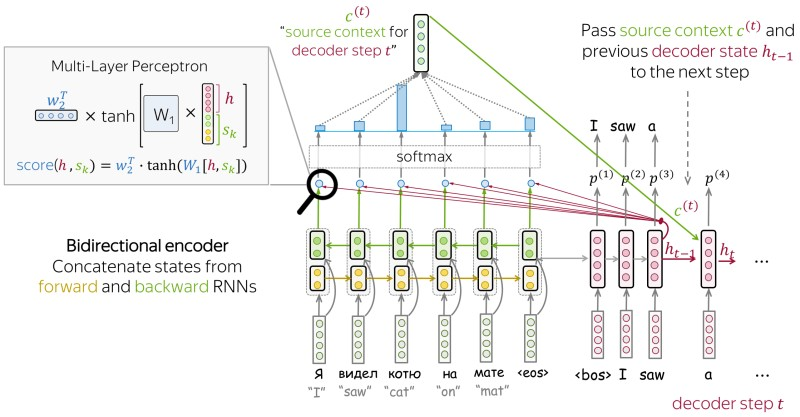

Image Source: [Lena Voita NLP](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html)

**Encoder**: Since the decoder is not bidirectional, the hidden states obtained as a result of forward and backward passes of bidirectional GRU are concatenated to form a vector of dim: **[2 * *enc_hid_dim*]**. It is then passed to fully connected network to output a vector of dim: **[*dec_hid_dim*]** 

In [12]:
class Encoder(nn.Module):
  
  def __init__(self,src_vocab_size,embed_dim,enc_hid_dim,dec_hid_dim):
    super(Encoder,self).__init__()
    self.embedding = nn.Embedding(src_vocab_size,embed_dim,padding_idx=1)
    self.BiGRU = nn.GRU(embed_dim,enc_hid_dim,batch_first=True,bidirectional=True)
    self.fc = nn.Linear(2*enc_hid_dim,dec_hid_dim)

  def forward(self,src):    
    """
    INPUT: 
      src: [batch_size,len(source_sentence)]
      hidden(implicit): [2,batch_size,enc_hid_dim]

    OUTPUT:
      out: [batch_size,len(source_sentence),2*enc_hid_dim]
      hidden: [batch_size,dec_hid_dim]
    """

    ## out: [batch_size,len(source_sentence),embed_dim]
    out = self.embedding(src)

    ## out: [batch_size,len(source_sentence),2*enc_hid_dim]
    ## hidden: [2,batch_size,enc_hid_dim]
    out, hidden = self.BiGRU(out)

    ## hidden: [batch_size,2*enc_hid_dim]
    hidden = torch.concat([hidden[-2,:,:],hidden[-1,:,:]],dim=1)

    ## hidden: [batch_size,dec_hid_dim], 
    hidden = torch.tanh(self.fc(hidden))

    return out, hidden

**Attention**: Alignment scores how well the inputs around position **j** and the output at position **i** match. It is defined by, 
<br>**a(s<sub>i−1</sub>, h<sub>j</sub> ) = v<sub>a</sub> tanh (W<sub>a</sub>s<sub>i−1</sub> + 
U<sub>a</sub>h<sub>j</sub> )**. <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**= v<sub>a</sub> tanh ([W<sub>a</sub> ; U<sub>a</sub>][s<sub>i−1</sub> ;
h<sub>j</sub>]<sup>T</sub>)**


In [13]:
class Attention(nn.Module):

  def __init__(self,enc_hid_dim,dec_hid_dim):
    super(Attention,self).__init__()
    self.energy = nn.Linear(2*enc_hid_dim + dec_hid_dim, dec_hid_dim)
    self.fc = nn.Linear(dec_hid_dim,1,bias=False)
    self.softmax = nn.Softmax(dim=1)
  
  def forward(self,enc_out,dec_hid):
    """
    INPUT:
      enc_out: [batch_size,len(source_sentence),2*enc_hid_dim]
      dec_hid: [batch_size,dec_hid_dim]

    OUTPUT:
      out: [batch_size,len(source_sentence),1]
    """
    batch_size = enc_out.shape[0]
    seq_length = enc_out.shape[1]

    ## dec_hid: [batch_size,len(source_sentence),dec_hid_dim]
    dec_hid = dec_hid.unsqueeze(1).repeat(1,seq_length,1)

    ## out_cat: [batch_size,len(source_sentence),2*enc_hid_dim + dec_hid_dim]
    out_cat = torch.concat([enc_out,dec_hid],dim=2)    

    ## out: [batch_size,len(source_sentence),dec_hid_dim]
    out = torch.tanh(self.energy(out_cat))

    ## out: [batch_size,len(source_sentence),1]
    attn = self.fc(out)

    return self.softmax(attn)

**Decoder**: This is slightly confusing. In this case, we concatenate the context vector (obtained as a result of the weighted sum of encoder hidden states) with the embedded target input. Why so? Idk. Concatenating the context vector with the hidden states of the decoder may make more sense. It's mostly experimental here.

In [14]:
class Decoder(nn.Module):

  def __init__(self,tgt_vocab_size,embed_dim,enc_hid_dim,dec_hid_dim,attention):
    super(Decoder,self).__init__()
    self.attention = attention     
    self.embedding = nn.Embedding(tgt_vocab_size,embed_dim,padding_idx=1)
    self.gru = nn.GRU(embed_dim+2*enc_hid_dim,dec_hid_dim,batch_first=True)
    self.fc = nn.Linear(dec_hid_dim,tgt_vocab_size)

  def forward(self,input,enc_out,dec_hid):
    """
    INPUT:
      input: [batch_size]
      enc_out: [batch_size,len(source_sentence),2*enc_hid_dim]
      dec_hid: [batch_size,dec_hid_dim]
      hidden(implicit): [1,batch_size,dec_hid_dim]

    OUTPUT:
      out: [batch_size,tgt_vocab_size]
      hidden: [batch_size,dec_hid_dim]   
    """
    ## attn_scores: [batch_size,len(source_sequence),1]
    attn_scores = self.attention(enc_out,dec_hid)  

    ## weighted_sum: [batch_size,1,2*enc_hid_dim]
    weighted_sum = torch.bmm(attn_scores.permute(0,2,1),enc_out)

    ## out: [batch_size,1]
    out = input.unsqueeze(1)

    ## out: [batch_size,1,embed_dim]
    out = self.embedding(out)

    ## out: [batch_size,1,embed_dim+2*enc_hid_dim]
    out = torch.concat([out,weighted_sum],dim=2)    

    ## out: [batch_size,1,dec_hid_dim]
    ## hidden: [1,batch_size,dec_hid_dim]
    out,hidden = self.gru(out,dec_hid.unsqueeze(0))

    ## out: [batch_size,tgt_vocab_size]
    out = self.fc(out.squeeze(1))

    return out, hidden.squeeze(0)

In [15]:
class seq2seq(nn.Module):

  def __init__(self,encoder,decoder,tgt_vocab_size):
    super(seq2seq,self).__init__()
    self.tgt_vocab_size = tgt_vocab_size
    self.encoder = encoder
    self.decoder = decoder

  def forward(self,src,tgt,teacher_force_ratio=0.5):
    """
    INPUT:
      src: [batch_size,len(source_sentence)]
      tgt: [batch_size,len(tgt_sentence)]

    OUTPUT:
      output: [batch_size,len(tgt_sentence),tgt_vocab_size]
    """
    batch_size = tgt.shape[0]
    seq_length = tgt.shape[1]

    output = torch.zeros(batch_size,seq_length,self.tgt_vocab_size)

    ## src_out: [batch_size,len(source_sentence),2*enc_hid_dim]
    ## hidden: [batch_size,dec_hid_dim]
    src_out,hidden = self.encoder(src)

    ## x: [batch_size]
    x = tgt[:,0]
    for t in range(seq_length):
      
      ## out: [batch_size,tgt_vocab_size]
      ## hidden: [batch_size,dec_hid_dim]
      out, hidden = self.decoder(x,src_out,hidden)   

      output[:,t,:] = out
      best_guess = out.argmax(1)
      x = tgt[:,t] if random.random() < teacher_force_ratio else best_guess

    return output

# Model Initialization

In [16]:
SRC_VOCAB_SIZE = len(de_vocab)
TGT_VOCAB_SIZE = len(en_vocab)
EMBED_DIM = 1024
ENC_HID_DIM = 512
DEC_HID_DIM = 512

In [17]:
encoder = Encoder(SRC_VOCAB_SIZE,EMBED_DIM,ENC_HID_DIM,DEC_HID_DIM)
attention = Attention(ENC_HID_DIM,DEC_HID_DIM)
decoder = Decoder(TGT_VOCAB_SIZE,EMBED_DIM,ENC_HID_DIM,DEC_HID_DIM,attention)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = seq2seq(encoder,decoder,TGT_VOCAB_SIZE).to(device)

In [19]:
def init_params(model_):
  for name,param in model_.named_parameters():
    if 'weight' in name:
      nn.init.normal_(param,mean=0.0,std=0.01)
    else:
      nn.init.zeros_(param)

model.apply(init_params)

seq2seq(
  (encoder): Encoder(
    (embedding): Embedding(7860, 1024, padding_idx=1)
    (BiGRU): GRU(1024, 512, batch_first=True, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (attention): Attention(
      (energy): Linear(in_features=1536, out_features=512, bias=True)
      (fc): Linear(in_features=512, out_features=1, bias=False)
      (softmax): Softmax(dim=1)
    )
    (embedding): Embedding(5883, 1024, padding_idx=1)
    (gru): GRU(2048, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=5883, bias=True)
  )
)

In [20]:
def count_parameters(model):
  return sum(param.numel() for param in model.parameters() if param.requires_grad)

print("Number of trainable params in Encoder: {:,}".format(count_parameters(encoder)))
print("Number of trainable params in Decoder: {:,}".format(count_parameters(decoder)))
print("Number of trainable params in seq2seq: {:,}".format(count_parameters(model)))

Number of trainable params in Encoder: 13,298,176
Number of trainable params in Decoder: 13,764,859
Number of trainable params in seq2seq: 27,063,035


# Model Training

In [21]:
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss(ignore_index=1)

In [22]:
def train(data_iter):
  model.train()
  epoch_loss = 0.0
  
  ## src: [batch_size,len(source_sentence)]
  ## tgt_data: [batch_size,len(english_sentence)]
  ## tgt_label: [batch_size,len(english_sentence)]
  for src,tgt_data,tgt_label in data_iter:
    optimizer.zero_grad()
    seq_length = tgt_data.shape[1]

    ## pred: [batch_size,seq_length,tgt_vocab_size]
    pred = model(src,tgt_data)
 
    ## pred: [batch_size*seq_length,tgt_vocab_size]
    pred = pred.reshape(batch_size*seq_length,-1).to(device)

    ## tgt_label: [batch_size*seq_length]
    tgt_label = tgt_label.reshape(-1)

    ## loss: [tgt_vocab_size]
    loss = loss_fn(pred,tgt_label)

    epoch_loss += loss.item()
    loss.backward()
    optimizer.step()
  
  return epoch_loss/len(data_iter)

In [23]:
torch.manual_seed(42)
num_epochs = 20
for epoch in range(num_epochs):
  loss = train(train_dl)
  print("EPOCH: {}, LOSS: {: .4f}".format(epoch,loss))

EPOCH: 0, LOSS:  5.6567
EPOCH: 1, LOSS:  5.4255
EPOCH: 2, LOSS:  5.2034
EPOCH: 3, LOSS:  4.4121
EPOCH: 4, LOSS:  3.5964
EPOCH: 5, LOSS:  3.0902
EPOCH: 6, LOSS:  2.7200
EPOCH: 7, LOSS:  2.4534
EPOCH: 8, LOSS:  2.2394
EPOCH: 9, LOSS:  2.0522
EPOCH: 10, LOSS:  1.8964
EPOCH: 11, LOSS:  1.7638
EPOCH: 12, LOSS:  1.6517
EPOCH: 13, LOSS:  1.5578
EPOCH: 14, LOSS:  1.4678
EPOCH: 15, LOSS:  1.4060
EPOCH: 16, LOSS:  1.3208
EPOCH: 17, LOSS:  1.2692
EPOCH: 18, LOSS:  1.2129
EPOCH: 19, LOSS:  1.1560


## Test Translation

In [27]:
def translate(src):
  model.eval()
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  src_tokenized = torch.tensor(de_pipeline(src),device=device).unsqueeze(0)

  seed = ["<bos>"]
  tgt_tokenized = en_vocab(seed)

  # src_out: [batch_size,len(source_sentence),2*enc_hid_dim]
  # hidden: [batch_size,dec_hid_dim] 
  src_out,hidden = encoder(src_tokenized)

  with torch.no_grad():
    while tgt_tokenized[-1] != "<eos>" and len(tgt_tokenized) < 10:
      input = torch.tensor(tgt_tokenized[-1],device=device).unsqueeze(0)  

      # out: [batch_size,tgt_vocab_size]
      # hidden: [batch_size,dec_hid_dim]
      out,hidden = decoder(input,src_out,hidden)
      probs = torch.softmax(out[0,:],dim=0)   
      prediction = torch.multinomial(probs,num_samples=1).item()

      if prediction in [0,1]:
        continue
      tgt_tokenized.append(prediction)

  itos = en_vocab.get_itos()
  tokens = [itos[i] for i in tgt_tokenized]
  return tokens

In [40]:
print("Actual: Two men at the boat, Predicted: ",translate("Zwei Männer am Boot"))
print("Actual: Today is such a great day, Predicted: ",translate("heute ist so ein toller Tag"))

Actual: Two men at the boat, Predicted:  ['<bos>', 'two', 'men', 'on', 'the', 'the', 'of', 'boat', '<eos>', 'boat']
Actual: Today is such a great day, Predicted:  ['<bos>', 'are', 'on', 'a', 'day', 'day', '<eos>', '<eos>', '<eos>', 'day']
